In [10]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [13]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/storage/camvid/.ipynb_checkpoints'),
 PosixPath('/storage/camvid/valid.txt'),
 PosixPath('/storage/camvid/images'),
 PosixPath('/storage/camvid/codes.txt'),
 PosixPath('/storage/camvid/labels')]

In [14]:
path_lbl = path/'labels'
path_img = path/'images'

In [15]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/storage/camvid/images/Seq05VD_f01350.png'),
 PosixPath('/storage/camvid/images/0001TP_010230.png'),
 PosixPath('/storage/camvid/images/Seq05VD_f01200.png')]

In [16]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/storage/camvid/labels/0016E5_08051_P.png'),
 PosixPath('/storage/camvid/labels/Seq05VD_f00000_P.png'),
 PosixPath('/storage/camvid/labels/0016E5_01350_P.png')]

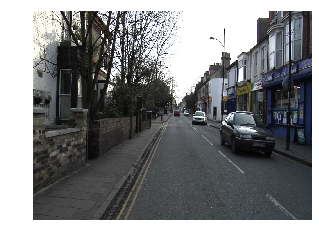

In [17]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [18]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

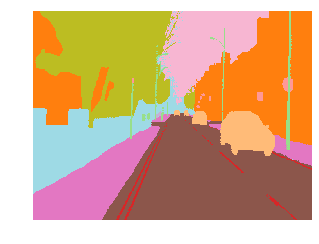

In [19]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [20]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [21]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [22]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 24437MB of GPU RAM free


In [23]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [24]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

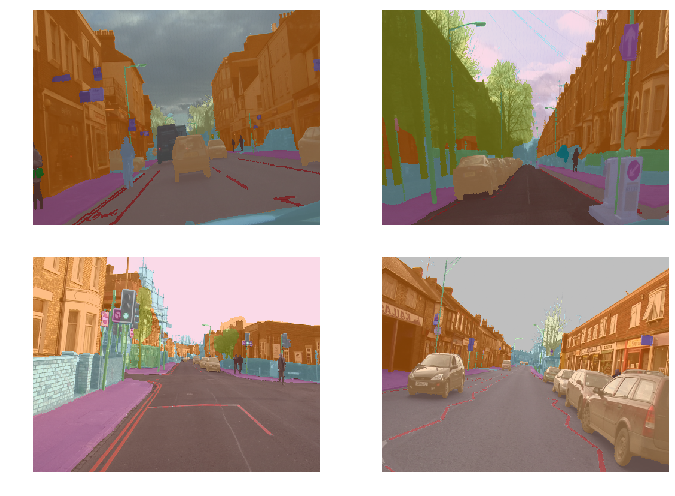

In [25]:
data.show_batch(2, figsize=(10,7))

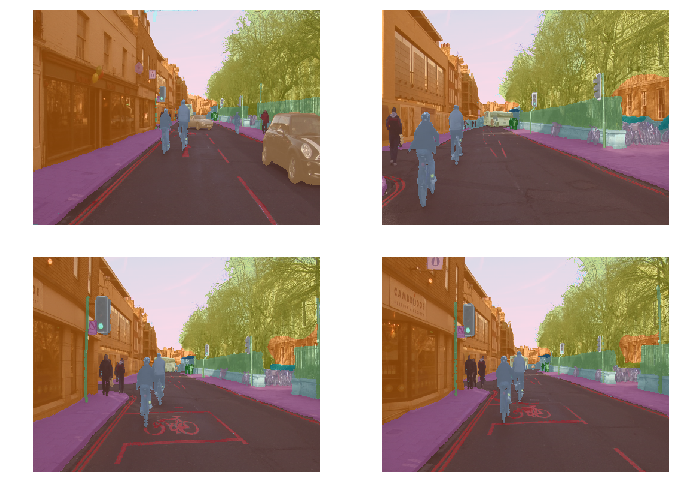

In [26]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [27]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [28]:
metrics=acc_camvid

In [29]:
wd=1e-2

In [30]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


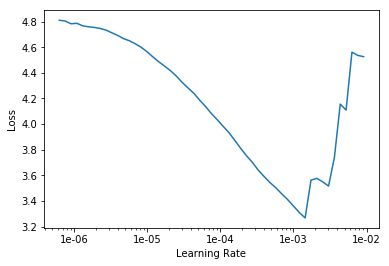

In [31]:
lr_find(learn)
learn.recorder.plot()

In [32]:
lr=1e-3

In [33]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.548840,0.976186,0.790330,00:50
1,0.968445,0.688436,0.830825,00:46
2,0.750959,0.579992,0.842381,00:46
3,0.679941,0.565848,0.848321,00:46
4,0.612644,0.528359,0.855758,00:46
5,0.567509,0.442247,0.886199,00:46
6,0.538779,0.402746,0.887668,00:46
7,0.516679,0.506442,0.862086,00:46
8,0.491190,0.410200,0.887558,00:46
9,0.420083,0.308206,0.910012,00:46


In [34]:
learn.save('stage-1')

In [35]:
learn.load('stage-1');

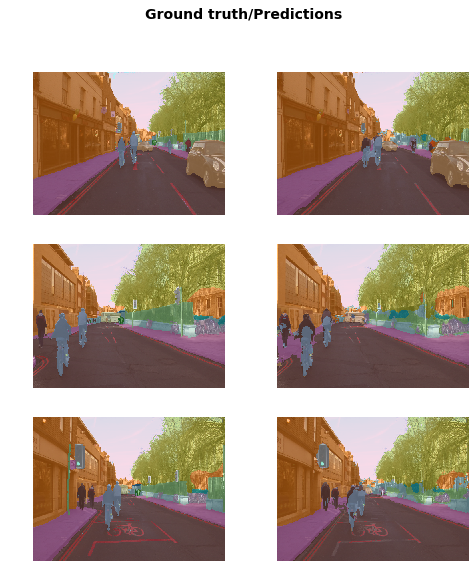

In [36]:
learn.show_results(rows=3, figsize=(8,9))

In [37]:
learn.unfreeze()

In [38]:
lrs = slice(lr/400,lr/4)

In [39]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.348786,0.301769,0.911387,00:48
1,0.342935,0.294242,0.914969,00:48
2,0.333633,0.290033,0.916729,00:48
3,0.325192,0.286636,0.914596,00:48
4,0.316054,0.293933,0.913526,00:48
5,0.315552,0.310455,0.906114,00:48
6,0.307210,0.323407,0.906767,00:48
7,0.300671,0.306118,0.910748,00:48
8,0.296551,0.283097,0.921856,00:48
9,0.289678,0.268229,0.923730,00:48


In [40]:
learn.save('stage-2');

In [41]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 23854MB of GPU RAM free


In [42]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [43]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [44]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


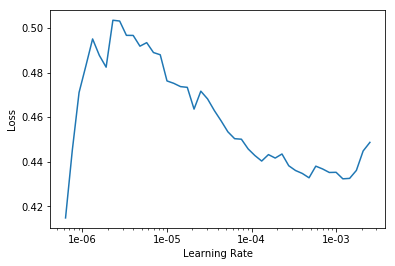

In [45]:
lr_find(learn)
learn.recorder.plot()

In [46]:
lr=1e-3

In [47]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.349049,0.305463,0.911409,03:11
1,0.342745,0.321826,0.907188,03:08
2,0.368241,0.308205,0.913631,03:08
3,0.375950,0.322285,0.905489,03:07
4,0.404240,0.318179,0.908171,03:07
5,0.423274,0.339213,0.911006,03:07
6,0.410706,0.330578,0.918974,03:07
7,0.363249,0.326558,0.916026,03:06
8,0.310753,0.271333,0.925573,03:06
9,0.245612,0.243863,0.931340,03:07


In [48]:
learn.save('stage-1-big')

In [49]:
learn.load('stage-1-big');

In [50]:
learn.unfreeze()

In [51]:
lrs = slice(1e-6,lr/10)

In [52]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.231961,0.244072,0.931504,03:14
1,0.236123,0.241463,0.932285,03:14
2,0.229246,0.247831,0.931449,03:13
3,0.217711,0.252595,0.930403,03:14
4,0.215857,0.249936,0.931278,03:14
5,0.212246,0.240210,0.934480,03:14
6,0.199670,0.252984,0.931571,03:14
7,0.196365,0.238645,0.934992,03:14
8,0.186611,0.236568,0.935770,03:14
9,0.181615,0.239365,0.934535,03:14


In [53]:
learn.save('stage-2-big')

In [54]:
learn.load('stage-2-big');

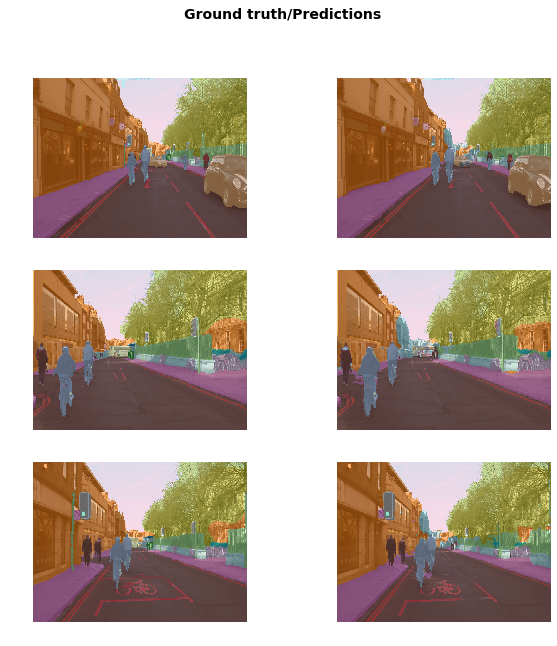

In [55]:
learn.show_results(rows=3, figsize=(10,10))

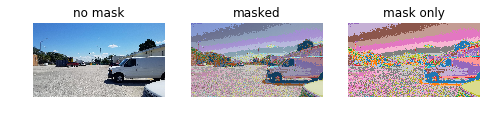

In [68]:
picture = open_image(path/'py1.jpg')
mask = open_mask(path/'py1.jpg')
_,axs = plt.subplots(1,3, figsize=(8,4))
img.show(ax=axs[0], title='no mask')
img.show(ax=axs[1], y=mask, title='masked')
mask.show(ax=axs[2], title='mask only', alpha=1.)


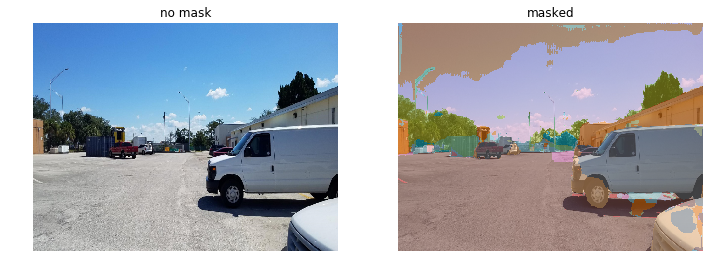

In [73]:
size = (1, 720, 960)

py1 = open_image(path/'py1.jpg')
py1_resized = py1.resize((size))
_,axs = plt.subplots(1,2, figsize=(12,12))
mask_1 = learn.predict(py1_resized)[0]
py1_resized.show(ax=axs[0], title='no mask')
py1_resized.show(ax=axs[1], y=mask_1, title='masked')

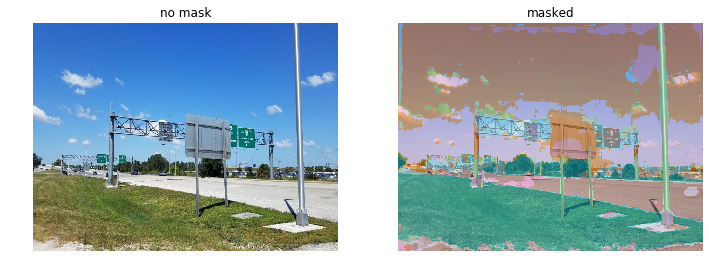

In [75]:
size = (1, 720, 960)

py2 = open_image(path/'py2.jpg')
py2_resized = py2.resize((size))
_,axs = plt.subplots(1,2, figsize=(12,12))
mask_2 = learn.predict(py2_resized)[0]
py2_resized.show(ax=axs[0], title='no mask')
py2_resized.show(ax=axs[1], y=mask_2, title='masked')

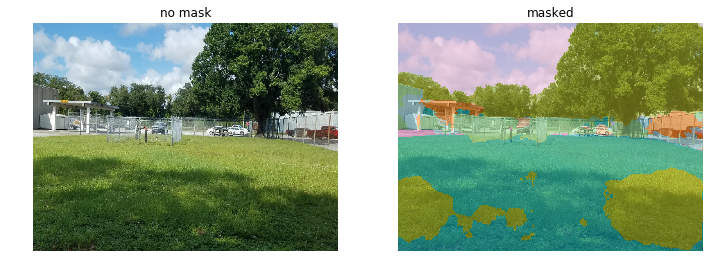

In [76]:
size = (1, 720, 960)

py3 = open_image(path/'py3.jpg')
py3_resized = py3.resize((size))
_,axs = plt.subplots(1,2, figsize=(12,12))
mask_3 = learn.predict(py3_resized)[0]
py3_resized.show(ax=axs[0], title='no mask')
py3_resized.show(ax=axs[1], y=mask_3, title='masked')

In [ ]:
Answers 

1. The model is having a little bit a hard time when totally new data is presented, but you can tell is giving vuluable
information, recognized grass, streets, sky, so the difficulty is basically unknow data, also i had to use paperspace cause 
colab was taking a lot of time wich is understandable, a lot of info and its free but is was a good challenge

2. We can use transfer learning that is one of the best ways to reuse a model trained on a related predictive modeling problem.